# PBMC data integration

We apply uniPort to integrate transcriptomic and epigenomic data using scATAC (gene activity matrix) and scRNA datasets profiled from peripheral blood mononuclear cells (PBMC), including 11259 paired cells with 19434 genes in scATAC and 26187 genes in scRNA.The PBMC data consists of paired scATAC-seq and scRNA-seq profiles, but we treat them as unpaired.

In [1]:
import uniport as up
import numpy as np
import pandas as pd
import scanpy as sc
print(up.__version__)

1.1.1


### Data preprocessing
Read cell types for both scATAC-seq and scRNA-seq

In [2]:
labels = pd.read_csv('PBMC/meta.txt', sep='\t')
celltype = labels['cluster'].values

Read gene activity matrix and RNA counts into `AnnData` objects using `load_file` fucntion in uniport.   

In [3]:
adata_atac = up.load_file('PBMC/gene_activity.txt')
adata_rna = up.load_file('PBMC/RNA_count.txt')

Add 'cell_type', 'domain_id' and 'source' to the `AnnData`objects.\
'cell_type' stores cell label annotations. \
'domain_id' identifies the modality using a number category. \
'source' identifies the modality using its name.

In [4]:
adata_atac.obs['cell_type'] = celltype
adata_atac.obs['domain_id'] = 0
adata_atac.obs['domain_id'] = adata_atac.obs['domain_id'].astype('category')
adata_atac.obs['source'] = 'ATAC'

adata_rna.obs['cell_type'] = celltype
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

Filter cells and features using `filter_data` function in uniport. 

In [5]:
up.filter_data(adata_atac, min_features=3, min_cells=200)
up.filter_data(adata_rna, min_features=3, min_cells=200)
print(adata_atac)
print(adata_rna)

AnnData object with n_obs × n_vars = 11259 × 14867
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 11259 × 11942
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells'


Concatenate scATAC-seq and scRNA-seq with common genes using `AnnData.concatenate`.

In [6]:
adata_cm = adata_atac.concatenate(adata_rna, join='inner', batch_key='domain_id')
print(adata_cm)

AnnData object with n_obs × n_vars = 22518 × 8275
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'


Preprocess data with common genes. Select 2,000 highly variable common genes. \
Scale data using `batch_scale` function in uniport (modified from [SCALEX](https://scalex.readthedocs.io/en/latest/api/index.html#preprocessing)).

In [7]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
up.batch_scale(adata_cm)
print(adata_cm.obs)

... storing 'cell_type' as categorical
... storing 'source' as categorical


                      cell_type domain_id source  n_genes
AAACAGCCAAGGAATC-1-0  CD4 Naive         0   ATAC     6292
AAACAGCCAATCCCTT-1-0   CD4 Tmem         0   ATAC     4165
AAACAGCCAATGCGCT-1-0  CD4 Naive         0   ATAC     3738
AAACAGCCACACTAAT-1-0  CD8 Naive         0   ATAC      680
AAACAGCCACCAACCG-1-0  CD8 Naive         0   ATAC     2230
...                         ...       ...    ...      ...
TTTGTTGGTGACATGC.1-1  CD8 Naive         1    RNA     1586
TTTGTTGGTGTTAAAC.1-1  CD8 Naive         1    RNA     1525
TTTGTTGGTTAGGATT.1-1         NK         1    RNA     2024
TTTGTTGGTTGGTTAG.1-1   CD4 Tmem         1    RNA     1620
TTTGTTGGTTTGCAGA.1-1   CD8 Tmem         1    RNA     1920

[22518 rows x 4 columns]


Preprocess scATAC-seq data.
Select 2,000 highly variable genes as ATAC speicifc.

In [8]:
sc.pp.normalize_total(adata_atac)
sc.pp.log1p(adata_atac)
sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_atac)
print(adata_atac.obs)

                    cell_type domain_id source  n_genes
AAACAGCCAAGGAATC-1  CD4 Naive         0   ATAC     6292
AAACAGCCAATCCCTT-1   CD4 Tmem         0   ATAC     4165
AAACAGCCAATGCGCT-1  CD4 Naive         0   ATAC     3738
AAACAGCCACACTAAT-1  CD8 Naive         0   ATAC      680
AAACAGCCACCAACCG-1  CD8 Naive         0   ATAC     2230
...                       ...       ...    ...      ...
TTTGTTGGTGACATGC-1  CD8 Naive         0   ATAC     3440
TTTGTTGGTGTTAAAC-1  CD8 Naive         0   ATAC     3648
TTTGTTGGTTAGGATT-1         NK         0   ATAC     2494
TTTGTTGGTTGGTTAG-1   CD4 Tmem         0   ATAC     3877
TTTGTTGGTTTGCAGA-1   CD8 Tmem         0   ATAC     3916

[11259 rows x 4 columns]


Preprocess scRNA-seq data. Select 2,000 highly variable genes as RNA specific.

In [9]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_rna)
print(adata_rna.obs)

                    cell_type domain_id source  n_genes
AAACAGCCAAGGAATC.1  CD4 Naive         1    RNA     3308
AAACAGCCAATCCCTT.1   CD4 Tmem         1    RNA     1896
AAACAGCCAATGCGCT.1  CD4 Naive         1    RNA     2904
AAACAGCCACACTAAT.1  CD8 Naive         1    RNA      846
AAACAGCCACCAACCG.1  CD8 Naive         1    RNA     2282
...                       ...       ...    ...      ...
TTTGTTGGTGACATGC.1  CD8 Naive         1    RNA     1586
TTTGTTGGTGTTAAAC.1  CD8 Naive         1    RNA     1525
TTTGTTGGTTAGGATT.1         NK         1    RNA     2024
TTTGTTGGTTGGTTAG.1   CD4 Tmem         1    RNA     1620
TTTGTTGGTTTGCAGA.1   CD8 Tmem         1    RNA     1920

[11259 rows x 4 columns]


Save the preprocessed data for integration.

In [10]:
adata_atac.write('PBMC/atac_processed.h5ad', compression='gzip')
adata_rna.write('PBMC/rna_processed.h5ad', compression='gzip')
adata_cm.write('PBMC/atac_and_rna.h5ad', compression='gzip')

... storing 'cell_type' as categorical
... storing 'source' as categorical
... storing 'cell_type' as categorical
... storing 'source' as categorical


### Integration with specific genes and optimal transport loss
Integrate the scATAC-seq and scRNA-seq data using both common and dataset-specific genes by `Run` function in uniport. The latent representations of data are stored in `adata.obs['latent']`.

In [11]:
adata = up.Run(adatas=[adata_atac, adata_rna], adata_cm=adata_cm, lambda_kl=1.0, lambda_s=1.0)

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'




Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [14:24<00:00,  2.51s/it, recloss=1143.28,klloss=12.49,otloss=5.70]


Before integration. Visualize the data using UMAP according to their cell types and sources.

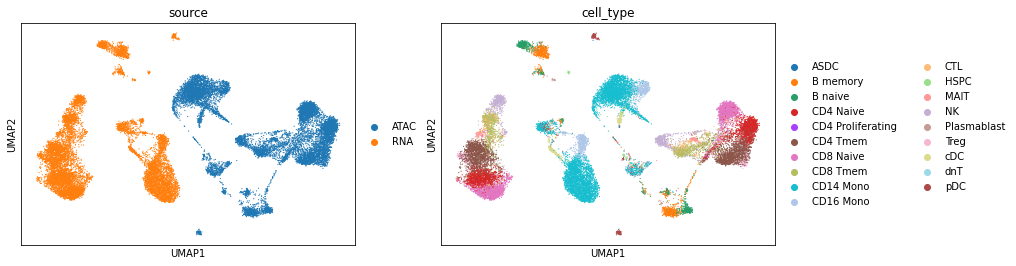

In [12]:
sc.pp.pca(adata_cm)
sc.pp.neighbors(adata_cm)
sc.tl.umap(adata_cm)
sc.pl.umap(adata_cm, color=['source', 'cell_type'])

After integration

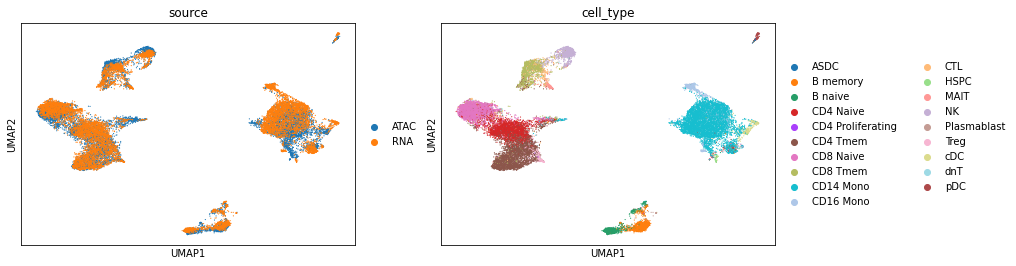

In [13]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Evaluate the results with various scores
We evaluated the results by F1, ARI, NMI, Batch Entropy and Silhouette scores.

In [14]:
adata1 = adata[adata.obs['domain_id']=='0']
adata2 = adata[adata.obs['domain_id']=='1']
y_test = up.metrics.label_transfer(adata2, adata1, label='cell_type', rep='X_umap')
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score
print('F1:', f1_score(adata1.obs['cell_type'], y_test, average='micro'))
print('ARI:', adjusted_rand_score(adata1.obs['cell_type'], y_test))
print('NMI:', normalized_mutual_info_score(adata1.obs['cell_type'], y_test))
print('Batch Entropy:', up.metrics.batch_entropy_mixing_score(adata.obsm['X_umap'], adata.obs['domain_id']))
print('Silhouette:', up.metrics.silhouette(adata.obsm['X_umap'], adata.obs['cell_type']))

F1: 0.7776889599431566
ARI: 0.6321860186421134
NMI: 0.6718827954523922
Batch Entropy: 0.5858338812322246
Silhouette: 0.5916472971439362


### Project data after training
To project data into the latent space without training, we can set `out='project'`.

In [15]:
adata_cm = sc.read_h5ad('PBMC/atac_and_rna.h5ad')

AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'project'


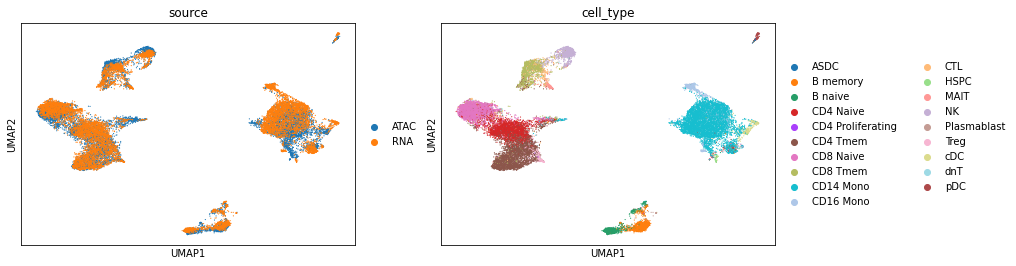

In [16]:
adata = up.Run(adata_cm=adata_cm, out='project')
print(adata)
sc.pp.neighbors(adata, use_rep='project')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Integration without specific genes
Integrate the scATAC-seq and scRNA-seq data using only common genes.

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'umap', 'source_colors', 'cell_type_colors'
    obsm: 'project', 'X_umap'
    obsp: 'distances', 'connectivities'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'umap', 'source_colors', 'cell_type_colors'
    obsm: 'project', 'X_umap'
    obsp: 'distances', 'connectivities'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'


Epochs: 100%|███████████████████████████████████| 345/345 [13:17<00:00,  2.31s/it, recloss=443.20,klloss=4.69,otloss=1.24]


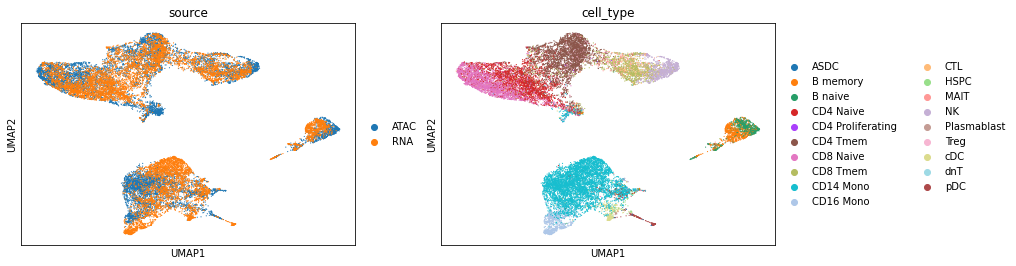

In [17]:
adata = up.Run(adata_cm=adata_cm, lambda_kl=1.0)
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])

### Integration without optimal transport loss
Integrate the scATAC-seq and scRNA-seq data without optimal transport loss.

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'




Epochs: 100%|███████████████████████████████████| 345/345 [14:02<00:00,  2.44s/it, recloss=794.56,klloss=9.28,otloss=0.00]


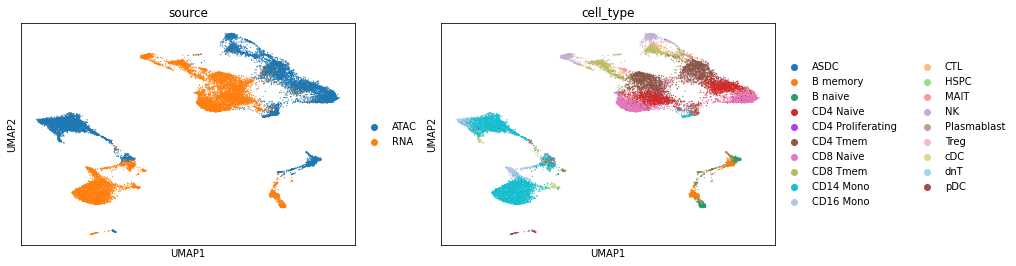

In [18]:
adata = up.Run(adatas=[adata_atac, adata_rna], adata_cm=adata_cm, lambda_kl=1.0, lambda_ot=0)
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])